In [1]:
!pip install yfinance
!pip install xgboost

  Using cached yfinance-0.1.70-py2.py3-none-any.whl (26 kB)
  Using cached multitasking-0.0.10-py3-none-any.whl
  Using cached xgboost-1.5.2-py3-none-manylinux2014_x86_64.whl (173.6 MB)


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import os


from xgboost import XGBClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, precision_score, f1_score

from sklearn.model_selection import learning_curve

import seaborn as sns
import matplotlib.pyplot as plt

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

def gen_ret(df, tickers): # generates daily returns 
    for ticker in tickers:
        ticker = ticker.lower()
        df.loc[:,f"ret_{ticker}"] = df.loc[:,f"adj close_{ticker}"].pct_change()
    return df

    
    return result

def gen_vol(df, tickers, lookback = 10): # generates ohlc volatility
    for ticker in tickers:
        ticker = ticker.lower()
        o = df.loc[:,'_'.join(['open', ticker])]
        h = df.loc[:,'_'.join(['high', ticker])]
        l = df.loc[:,'_'.join(['low', ticker])]
        c = df.loc[:,'_'.join(['close', ticker])]

        k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
        cc = np.log(c/c.shift(1))
        ho = np.log(h/o)
        lo = np.log(l/o)
        co = np.log(c/o)
        oc = np.log(o/c.shift(1))
        oc_sq = oc**2
        cc_sq = cc**2
        rs = ho*(ho-co)+lo*(lo-co)
        close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
        open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
        window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
        result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
        result[:lookback-1] = np.nan

        df.loc[:,f'vol_{ticker}'] = result
    return df

def gen_rsi(df, tickers, periods = 14, ema = True): # technical indicator: Relative Strength Index
    for ticker in tickers: 
        ticker = ticker.lower()
        close_delta = df[f"adj close_{ticker}"].diff()

        up = close_delta.clip(lower=0)
        down = -1 * close_delta.clip(upper=0)

        if ema == True:
            ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
            ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        else:
            ma_up = up.rolling(window = periods, adjust=False).mean()
            ma_down = down.rolling(window = periods, adjust=False).mean()
        rs = ma_up / ma_down
        rsi = 100 - 100 / (1+rs)
        df.loc[:,f"rsi_{ticker}"] = rsi
    
    return df

def gen_stok(df, tickers, periods = 14): # technical indicator: stocastic oscillator k%
    
    for ticker in tickers: 
        ticker = ticker.lower()
        hh = df.loc[:,f"high_{ticker}"].rolling(periods).max()
        ll = df.loc[:,f"low_{ticker}"].rolling(periods).min()
        df.loc[:,f"stok_{ticker}"] = 100 * (df.loc[:,f"adj close_{ticker}"] - ll) / (hh - ll)
        
    return df

def gen_wilr(df, tickers, periods = 14): # technical indicator: William's R%
    
    for ticker in tickers: 
        ticker = ticker.lower()
        hh = df.loc[:,f"high_{ticker}"].rolling(periods).max()
        ll = df.loc[:,f"low_{ticker}"].rolling(periods).min()
        df.loc[:,f"wilr_{ticker}"] = (hh - df.loc[:,f"adj close_{ticker}"]) / (hh - ll) * (-100)
    
    return df

def gen_macd(df, tickers, periods = (12, 26, 9)): # technical indicator: MACD - MACD_signal
    for ticker in tickers:
        ticker = ticker.lower()
        k = df[f"adj close_{ticker}"].ewm(span=periods[0], adjust=False, min_periods=periods[0]).mean()
        d = df[f"adj close_{ticker}"].ewm(span=periods[1], adjust=False, min_periods=periods[1]).mean()
        macd = k - d
        macd_s = macd.ewm(span=periods[2], adjust=False, min_periods=periods[2]).mean()
        df.loc[:,f"macd_{ticker}"] = macd - macd_s

    return df

def gen_obv(df, tickers, periods = 14): # technical indicator: OBV - OBV exponential MA 
    for ticker in tickers:
        ticker = ticker.lower()
        ac = data.loc[:,f"adj close_{ticker}"]
        vo = data.loc[:,f"volume_{ticker}"]
        obv = ((ac.diff() > 0)*1 - (ac.diff() < 0)*1) * vo
        obv_ema = pd.DataFrame(obv).ewm(span = periods, adjust = False, min_periods = periods).mean()
        df.loc[:,f"obv_{ticker}"] = obv_ema
    return df

def gen_retbbk(df, tickers, periods = 14): # technical indicator: Bollinger Band coefficient k
    for ticker in tickers: 
        ticker = ticker.lower()
        ret = data.loc[:, f"ret_{ticker}"] 
        ma = ret.rolling(periods).mean()
        std = ret.rolling(periods).std()
        df.loc[:,f"retbbk_{ticker}"] = (ret - ma)/std
    return df
        

def gen_features(df, tickers):
    df = gen_ret(df, tickers)
    df = gen_vol(df, tickers)
    df = gen_rsi(df, tickers)
    df = gen_stok(df, tickers)
    df = gen_wilr(df, tickers)
    df = gen_macd(df, tickers)
    df = gen_obv(df, tickers)
    df = gen_retbbk(df, tickers)
    
    return df 


In [3]:
tickers = ["GOOG", "FB", "MSFT", 
           "SPY", "NVDA", "AMD", 
           "AAPL", "AMZN", "NFLX"]
data = yf.download(tickers, "2017-1-1", "2021-12-31", interval = "1d")
data.columns = ['_'.join(col).lower().strip() for col in data.columns.values]
data.to_csv("data.csv", index = True)
data = pd.read_csv("data.csv")
# ticker = 'goog'
# data.loc[:,[x for x in data.columns if ticker.lower() in x]]
data = gen_features(data, tickers = tickers)
data.to_csv("featured_data.csv", index = True)
data

[*********************100%***********************]  9 of 9 completed


,Date,adj close_aapl,adj close_amd,adj close_amzn,adj close_fb,adj close_goog,adj close_msft,adj close_nflx,adj close_nvda,adj close_spy,...,obv_nflx,retbbk_goog,retbbk_fb,retbbk_msft,retbbk_spy,retbbk_nvda,retbbk_amd,retbbk_aapl,retbbk_amzn,retbbk_nflx
0,2017-01-03,27.332474,11.430000,753.669983,116.860001,786.140015,58.185516,127.489998,25.170740,206.147522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,27.301876,11.430000,757.179993,118.690002,786.900024,57.925179,129.410004,25.757999,207.373962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-05,27.440720,11.240000,780.450012,120.669998,794.020020,57.925179,131.809998,25.104116,207.209183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-06,27.746635,11.320000,795.989990,123.410004,806.150024,58.427258,131.070007,25.439692,207.950531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-09,28.000778,11.490000,796.919983,124.900002,806.650024,58.241295,130.949997,26.471090,207.264099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2021-12-23,176.279999,146.139999,3421.370117,335.239990,2942.850098,334.690002,614.090027,296.399994,470.600006,...,NaN,-0.075580,0.435435,0.089978,0.283055,0.213743,0.352164,-0.125094,-0.036961,-0.112650
1254,2021-12-27,180.330002,154.360001,3393.389893,346.179993,2961.280029,342.450012,613.119995,309.450012,477.260010,...,NaN,0.293958,1.467277,0.966726,0.946762,0.878513,1.182005,0.764234,-0.470436,-0.115801
1255,2021-12-28,179.289993,153.149994,3413.219971,346.220001,2928.959961,341.250000,610.710022,303.220001,476.869995,...,NaN,-0.863624,-0.282892,-0.262214,-0.230229,-0.390944,-0.316595,-0.460349,0.570046,-0.167612
1256,2021-12-29,179.380005,148.259995,3384.020020,342.940002,2930.090088,341.950012,610.539978,300.010010,477.480011,...,NaN,0.118846,-0.705655,0.021304,-0.021352,-0.174168,-0.836846,-0.072689,-0.408115,0.121350


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


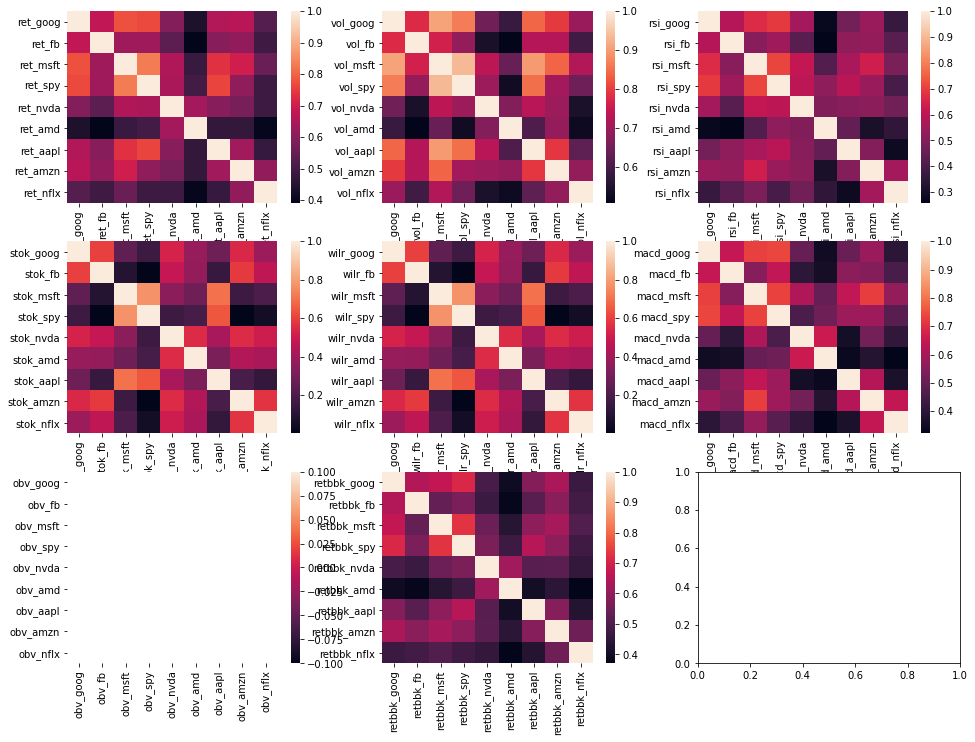

In [4]:
# EDA Plotting, correlation plots: 
fig, ax = plt.subplots(3, 3, figsize = [16,12])
feature_list = ["ret", "vol", "rsi", 
                "stok", "wilr", "macd",
                "obv", "retbbk"] 
for i in range(len(feature_list)):
    sns.heatmap(data.loc[:,[x for x in data.columns if feature_list[i]+'_' in x]].corr(),
                ax = ax[i//3, i%3])
# sns.heatmap(data.loc[:,[x for x in data.columns if 'ret_' in x]].corr())

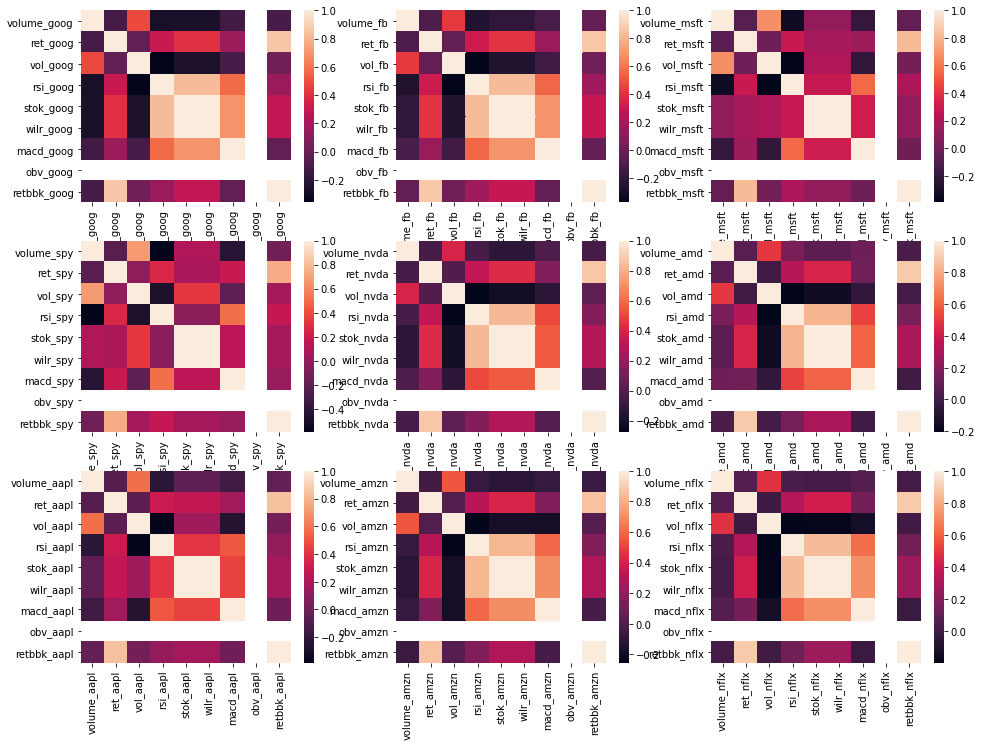

In [5]:
# EDA Plotting, inter-feature correlation plots: 
fig, ax = plt.subplots(3, 3, figsize = [16,12])
for i in range(len(tickers)):
    sns.heatmap(data.loc[:,[
        x for x in data.columns if (tickers[i].lower() in x) 
            and ("high" not in x)
            and ("low" not in x)
            and ("close" not in x)
            and ("open" not in x)
                           ]
                        ].corr(),
                ax = ax[i//3, i%3])
# sns.heatmap(data.loc[:,[x for x in data.columns if 'ret_' in x]].corr())

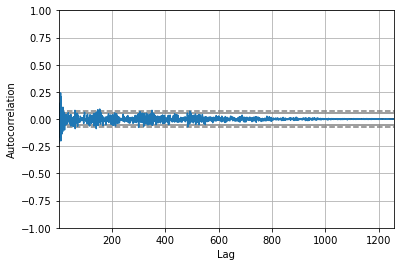

In [64]:
from pandas.plotting import scatter_matrix, autocorrelation_plot
y = data.loc[:,"ret_spy"]
autocorrelation_plot(y[1:])
plt.savefig("AR")

         Date  adj close_spy   close_spy    high_spy     low_spy    open_spy  \
0  2017-01-03     206.147522  225.240005  225.830002  223.880005  225.039993   
1  2017-01-04     207.373962  226.580002  226.750000  225.610001  225.619995   
2  2017-01-05     207.209183  226.399994  226.580002  225.479996  226.270004   
3  2017-01-06     207.950531  227.210007  227.750000  225.899994  226.529999   
4  2017-01-09     207.264099  226.460007  227.070007  226.419998  226.910004   

   volume_spy   ret_spy  vol_spy  rsi_spy  stok_spy  wilr_spy  macd_spy  \
0    91366500       NaN      NaN      NaN       NaN       NaN       NaN   
1    78744400  0.005949      NaN      NaN       NaN       NaN       NaN   
2    78379000 -0.000795      NaN      NaN       NaN       NaN       NaN   
3    71559900  0.003578      NaN      NaN       NaN       NaN       NaN   
4    46939700 -0.003301      NaN      NaN       NaN       NaN       NaN   

   obv_spy  retbbk_spy  
0      NaN         NaN  
1      NaN        

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


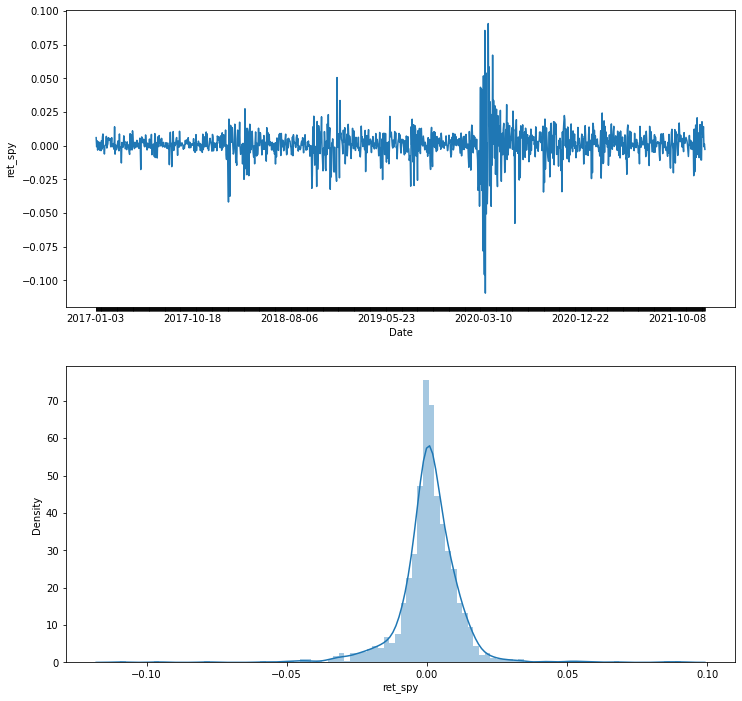

In [37]:
spy = data.loc[:,[x for x in data.columns if 'spy' in x or 'Date' in x]]
print(spy.head(5))
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2,1, figsize = [12,12])
# ax[0].grid()
# ax[0].plot(spy.ret_spy)
# # ax[0].set_xlabel([str(x) for x in spy.Date])
# for idx, xlabel_i in enumerate(ax[0].get_xticklabels()):
#     if idx % 100 != 0:
#         xlabel_i.set_visible(False)
sns.lineplot(x = 'Date', y = 'ret_spy', data = spy, ax = ax[0])
for idx, xlabel_i in enumerate(ax[0].get_xticklabels()):
    if idx % 200 != 0:
        xlabel_i.set_visible(False)
        
sns.distplot(spy.ret_spy, ax = ax[1], bins = 100)

plt.savefig("viz1.png")

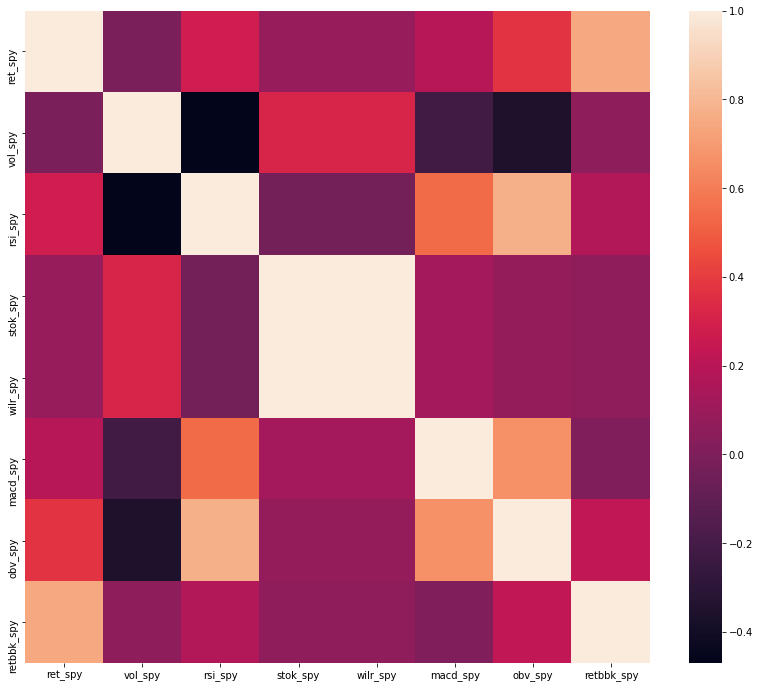

In [59]:
fd = pd.read_csv("featured_data.csv").loc[:,[x for x in fd.columns if ('lag' not in x) 
                                             and ('high' not in x)
                                            and ('low' not in x)
                                            and ('close' not in x)
                                            and ('open' not in x)
                                            and ('spy' in x)
                                             and ('volume' not in x)
                                            or ('date' in x.lower())]
                                         ]
fig, ax = plt.subplots(1,1, figsize = [14,12])

sns.heatmap(fd.corr())
plt.savefig("corr.png")

In [12]:

from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
pipeline = Pipeline([
    # ('feature_selector', FeatureSelector(['ret_spy'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)), 
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', XGBClassifier(n_estimators=100, random_state=0, 
                              use_label_encoder=False,
                             eval_metric = "logloss"))
])

def evaluate_model(model, X, y, train_size = 20, test_size = 1):
    cv = TimeSeriesSplit(
                       n_splits=int(len(X)/test_size)-train_size, 
                       test_size=1, 
                       max_train_size= train_size
                      )
    scorer = make_scorer(accuracy_score, greater_is_better=False, squared=False)
    
    return cross_validate(model, X, y, cv=cv, 
                                  # scoring=scorer, 
                                  n_jobs=-1)['test_score']

ticker = "msft"
# evaluate_model(pipeline, X, y)
X_col = [
        x for x in data.columns if ("_" in x)
             and ((ticker in x) or ("spy" in x))
             and ("adj close_" not in x)
             and ("close_" not in x)
             and ("high_" not in x)
             and ("open_" not in x)
             and ("volume_" not in x) 
             and ("low_" not in x) 
             # and ("ret_" not in x)
            
        ]

X = data[X_col]
print(X_col)

# print(X.shape)
y = ((data.loc[:,f"ret_{ticker}"].shift(-1) < -0.01) * 1)

# impute = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)
# scale = StandardScaler()
# model = RandomForestClassifier()

# X = scale.fit_transform(impute.fit_transform(X))
# y = (y>0)

# evaluate_model(pipeline, X, y)

tscv = TimeSeriesSplit(
                       n_splits=len(X)-20, 
                       test_size=1, 
                       max_train_size=20 
                      )
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print(type(train_index))
#     print(list(train_index))
#     print(type(list(train_index)))
#     break
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
folds = [(list(train_index), list(test_index)) 
         for train_index, test_index in tscv.split(X)
        ]
folds
# cross_validate(pipeline, X, y, cv = tscv)['test_score'].mean()

# grid_search = False
# if grid_search:
#     search = GridSearchCV(pipeline, {
#         # 'pca__n_components': [1,2,3],
#         'model__learning_rate': [0.0001, 0.0003, 0.0005, 0.001],
#         'model__reg_alpha':[0.5, 0.52, 0.55],
#         'model__min_child_weight':[6, 7, 10],
#     }, refit=True, cv=tscv, n_jobs=-1)
#     search.fit(X, y)
#     print("best params", search.best_params_)
#     best_model = search.best_estimator_
#     evaluation = evaluate_model(best_model, X, y)
#     print(evaluation)
#     print(evaluation.mean())
# else:
#     evaluation = evaluate_model(pipeline, X, y)
#     print(evaluation)
#     print(evaluation.mean())
    
# cross_validate(best_model, X, y, cv = tscv)['test_score'].mean()

['ret_msft', 'ret_spy', 'vol_msft', 'vol_spy', 'rsi_msft', 'rsi_spy', 'stok_msft', 'stok_spy', 'wilr_msft', 'wilr_spy', 'macd_msft', 'macd_spy', 'obv_msft', 'obv_spy', 'retbbk_msft', 'retbbk_spy']


[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [20]),
 ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [21]),
 ([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
  [22]),
 ([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
  [23]),
 ([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
  [24]),
 ([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
  [25]),
 ([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
  [26]),
 ([7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26],
  [27]),
 ([8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27],
  [28]),
 ([9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

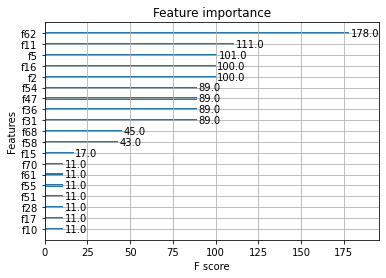

In [159]:
# target -0.01, ticker goog, model PCA+XGBRF, accuracy 0.745417515274949, 
# target -0.01, ticker goog, model No PCA+XGB, accuracy 0.7240325865580448, 
# target -0.02, ticker goog, model PCA+XGBRF, accuracy 0.8930753564154786, 
# target -0.02, ticker goog, model PCA+XGB, accuracy 0.90,
    #hypertuned, params: {'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__reg_alpha': 0.1, 'pca__n_components': 1}
# target -0.01, ticker goog, model PCA+XGB, accuracy 0.7781155015197568
    #hypertuned, params: {'model__learning_rate': 0.003, 'model__max_depth': 1, 'model__reg_alpha': 0.5, 'pca__n_components': 1}
# target -0.01, ticker goog, model No PCA+XGBRF, accuracy 0.7730496453900709
    #hypertuned, params: {'model__learning_rate': 0.001, 'model__max_depth': 1, 'model__reg_alpha': 0.9}
# * No PCA from now on. 
# target -0.01, ticker goog, model XGB, accuracy 0.7973657548125633
    #hypertuned, params: {'model__gamma': 0.0, 'model__learning_rate': 0.001, 'model__min_child_weight': 6, 'model__reg_alpha': 0.5}
from xgboost import plot_importance
plot_importance(best_model['model'])


In [160]:
print([x for x in enumerate(X.columns)])

[(0, 'ret_goog'), (1, 'ret_fb'), (2, 'ret_msft'), (3, 'ret_spy'), (4, 'ret_nvda'), (5, 'ret_amd'), (6, 'ret_aapl'), (7, 'ret_amzn'), (8, 'ret_nflx'), (9, 'vol_goog'), (10, 'vol_fb'), (11, 'vol_msft'), (12, 'vol_spy'), (13, 'vol_nvda'), (14, 'vol_amd'), (15, 'vol_aapl'), (16, 'vol_amzn'), (17, 'vol_nflx'), (18, 'rsi_goog'), (19, 'rsi_fb'), (20, 'rsi_msft'), (21, 'rsi_spy'), (22, 'rsi_nvda'), (23, 'rsi_amd'), (24, 'rsi_aapl'), (25, 'rsi_amzn'), (26, 'rsi_nflx'), (27, 'stok_goog'), (28, 'stok_fb'), (29, 'stok_msft'), (30, 'stok_spy'), (31, 'stok_nvda'), (32, 'stok_amd'), (33, 'stok_aapl'), (34, 'stok_amzn'), (35, 'stok_nflx'), (36, 'wilr_goog'), (37, 'wilr_fb'), (38, 'wilr_msft'), (39, 'wilr_spy'), (40, 'wilr_nvda'), (41, 'wilr_amd'), (42, 'wilr_aapl'), (43, 'wilr_amzn'), (44, 'wilr_nflx'), (45, 'macd_goog'), (46, 'macd_fb'), (47, 'macd_msft'), (48, 'macd_spy'), (49, 'macd_nvda'), (50, 'macd_amd'), (51, 'macd_aapl'), (52, 'macd_amzn'), (53, 'macd_nflx'), (54, 'obv_goog'), (55, 'obv_fb'), 